In [237]:
import torch.nn as nn
import torch
import torchvision.transforms
import os
from PIL import Image
from itertools import chain
import generate 
import torch.optim as optim
from livelossplot import PlotLosses

# More fonts, data augmentation (multiple character locations)

In [238]:
IMAGE_CHANNELS = 3
IMAGE_DIMENSION = 100

In [239]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [240]:
class FCCharacterNet(nn.Module):

    def __init__(self, num_labels, h=100, w=100, image_channels=3):
        super(FCCharacterNet, self).__init__()
        
        self.h = h
        self.w = w
        self.image_channels = image_channels
        self.num_labels = num_labels
        
        self.fc_inputs = image_channels * h * w
        
        self.fc1 = nn.Linear(in_features=self.fc_inputs, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=250)
        self.fc3 = nn.Linear(in_features=250, out_features=num_labels)
        #torch.nn.init.xavier_uniform_(self.fc1.weight)
        
        #self.relu = nn.ReLU()
        #self.relu = nn.LeakyReLU(negative_slope=0.1)
        self.relu = nn.Sigmoid()
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        # X: B 3 W H
        image_channels = x.size(1)
        H = x.size(2)
        W = x.size(3)

        x = x.view(-1, image_channels * H * W)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        #x = self.relu(x)
        
        x = self.softmax(x)
        
        return x

In [241]:
def load_image(path):
    """This function loads an image into memory when you give it
       the path of the image
    """
    img = Image.open(path)
    img.load()

    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    
    return transform(img)


In [242]:
path = '/home/chris/code/font-learning/images/Great_Vibes/52.png'
input1 = load_image(path)
print(input1.size())
batch = input1.unsqueeze(0)
print(batch.size())

torch.Size([3, 100, 100])
torch.Size([1, 3, 100, 100])


In [243]:
in_list = []
out_list = []

for font_idx, font_name in enumerate(generate.fonts):
        
    out_row = [1 if x == font_idx else 0 for x in range(len(generate.fonts))]
    
    for character in chain(range(ord("a"), ord("z")), range(ord("A"), ord("Z")), range(ord("0"), ord("9"))):
        image = load_image(f"images/{font_name}/{character}.png")
        in_list.append(image)
        
        out_list.append(torch.tensor(out_row, dtype=torch.float32))

#in_list = [in_list[0], in_list[-1]]
#out_list = [out_list[0], out_list[-1]]

inputs = torch.stack(in_list).to(device)
true_classes = torch.stack(out_list).to(device)

In [244]:
net = FCCharacterNet(num_labels=len(generate.fonts)).to(device)
criterion = nn.MSELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.000005)

In [245]:
outputs = net(inputs)
loss = criterion(outputs, true_classes)
loss

tensor(0.1612, device='cuda:0', grad_fn=<MseLossBackward>)

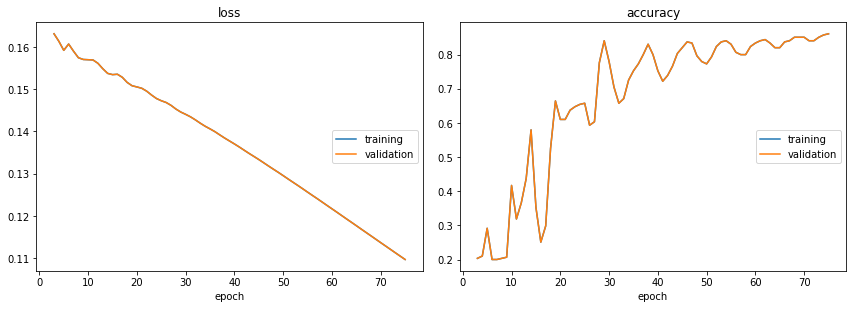

loss:
training   (min:    0.110, max:    0.165, cur:    0.110)
validation (min:    0.110, max:    0.165, cur:    0.110)

accuracy:
training   (min:    0.200, max:    0.861, cur:    0.861)
validation (min:    0.200, max:    0.861, cur:    0.861)


In [246]:
n_epochs = 75
liveloss = PlotLosses()

for epoch_idx in range(n_epochs):
    log_losses = {}
    
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize
    outputs = net(inputs)

    loss = criterion(outputs, true_classes)
    loss.backward()
    optimizer.step()
    
    guess_idxs = outputs.detach().max(1)[1]
    expected_idxs = true_classes.max(1)[1]
    
    #print(outputs)
    #print(guess_idxs)
    #print(expected_idxs)
    
    #print(f'Epoch {epoch_idx} loss: {loss:0.5f}')
    accuracy = 1.0 * guess_idxs.eq(expected_idxs).sum().item() / guess_idxs.size(0)
    #print(accuracy)
    log_losses['loss'] = loss.item()
    log_losses['val_loss'] = loss.item()
    log_losses['accuracy'] = accuracy
    log_losses['val_accuracy'] = accuracy
    liveloss.update(log_losses)
    
    # print statistics
    #if epoch_idx % n_epochs // 25  == 0:
    #    liveloss.draw()
    liveloss.draw()


In [14]:
outputs = net(inputs)
for i in range(len(outputs)):
    guesses = [f'{c:0.3f}' for c in outputs[i].tolist()]
    trues = [f'{c:0.3f}' for c in true_classes[i].tolist()]
    print(f'{guesses}: {trues}')



['0.818', '0.006', '0.107', '0.066', '0.003']: ['1.000', '0.000', '0.000', '0.000', '0.000']
['0.966', '0.000', '0.020', '0.013', '0.001']: ['1.000', '0.000', '0.000', '0.000', '0.000']
['0.632', '0.071', '0.244', '0.046', '0.007']: ['1.000', '0.000', '0.000', '0.000', '0.000']
['0.839', '0.009', '0.122', '0.030', '0.000']: ['1.000', '0.000', '0.000', '0.000', '0.000']
['0.789', '0.017', '0.149', '0.041', '0.004']: ['1.000', '0.000', '0.000', '0.000', '0.000']
['0.631', '0.016', '0.081', '0.177', '0.095']: ['1.000', '0.000', '0.000', '0.000', '0.000']
['0.914', '0.004', '0.043', '0.038', '0.002']: ['1.000', '0.000', '0.000', '0.000', '0.000']
['0.873', '0.002', '0.049', '0.070', '0.007']: ['1.000', '0.000', '0.000', '0.000', '0.000']
['0.634', '0.071', '0.090', '0.151', '0.054']: ['1.000', '0.000', '0.000', '0.000', '0.000']
['0.577', '0.066', '0.099', '0.210', '0.048']: ['1.000', '0.000', '0.000', '0.000', '0.000']
['0.800', '0.003', '0.114', '0.046', '0.038']: ['1.000', '0.000', '0.0

In [194]:
list(outputs.tolist())

[[2.1860256043467146e-43, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 1.0]]